In [54]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Conv2D, MaxPooling2D, Flatten, UpSampling2D, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
%matplotlib inline

batch_size = 100
original_dim = (28,28,1)
latent_dim = 2
intermediate_dim = 128
filter_size_1 = 32
filter_size_2 = 16
epochs = 10
epsilon_std = 1.0

import keras

In [67]:
x = Input(shape=original_dim)

h_1 = Conv2D(filter_size_2, strides=(2,2), kernel_size=(3,3), padding='same', activation='relu')(x)
#mp_1 = MaxPooling2D(strides=(2,2))(h_1)
# 14x14x4 feature map
h_2 = Conv2D(filter_size_2, kernel_size=(3,3), padding='same', activation='relu')(h_1)
# 14x14x4 feature map
h_3 = Conv2D(filter_size_2, kernel_size=(3,3), padding='same', activation='relu')(h_2)

h_4 = Conv2D(filter_size_2, kernel_size=(3,3), padding='same', activation='relu')(h_3)
# 14x14x4 feature map

flat = Flatten()(h_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Reconstruct vector
decoder_v = Dense(intermediate_dim, activation='relu')
# Reconstruct feature map
decoder_upsample = Dense(14 * 14 * filter_size_2 , activation='relu')
#
decoder_reshape = Reshape((14,14,filter_size_2))

decoder_h_1 = Conv2D(filter_size_2, kernel_size=(3,3), padding='same', activation='relu')

decoder_h_2 = Conv2D(filter_size_2, kernel_size=(3,3), padding='same', activation='relu')

decoder_h_3 = Conv2D(filter_size_2, kernel_size=(3,3), padding='same', activation='relu')

decoder_up_out = UpSampling2D(size=(2,2))
decoder_h_output = Conv2D(1, kernel_size=(3,3), padding='same', activation='relu')

d_v = decoder_v(z)
d_upsample = decoder_upsample(d_v)
d_reshape = decoder_reshape(d_upsample)
d_h1 = decoder_h_1(d_reshape)
d_h2 = decoder_h_2(d_h1)
d_h3 = decoder_h_3(d_h2)
d_up_out = decoder_up_out(d_h3)
d_out = decoder_h_output(d_up_out)

def vae_loss(x, d_out):
    x = K.flatten(x)
    d_out = K.flatten(d_out)
    xent_loss = original_dim[0] * original_dim[1] * metrics.binary_crossentropy(x, d_out)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

# instantiate VAE model
vae = Model(x, d_out)
vae.compile(optimizer='rmsprop', loss=vae_loss)
print(vae.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 14, 14, 16)   160         input_30[0][0]                   
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 14, 14, 16)   2320        conv2d_114[0][0]                 
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 14, 14, 16)   2320        conv2d_115[0][0]                 
__________________________________________________________________________________________________
conv2d_117

In [68]:
from keras.utils import plot_model
plot_model(vae, to_file='model.png',show_shapes=True)

In [69]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), original_dim[0], original_dim[1], 1))
x_test = x_test.reshape((len(x_test), original_dim[0], original_dim[1], 1))


print(x_test.shape)

vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

(10000, 28, 28, 1)
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 119us/step - loss: 186.3391 - val_loss: 158.5807
Epoch 2/10
60000/60000 [==============================] - 6s 104us/step - loss: 154.6757 - val_loss: 154.0270
Epoch 3/10
60000/60000 [==============================] - 6s 104us/step - loss: 149.4944 - val_loss: 146.8879
Epoch 4/10
60000/60000 [==============================] - 6s 104us/step - loss: 146.4817 - val_loss: 144.3333
Epoch 5/10
60000/60000 [==============================] - 6s 104us/step - loss: 144.5537 - val_loss: 144.1840
Epoch 6/10
60000/60000 [==============================] - 6s 104us/step - loss: 143.1641 - val_loss: 142.5937
Epoch 7/10
60000/60000 [==============================] - 6s 104us/step - loss: 142.0132 - val_loss: 143.9700
Epoch 8/10
60000/60000 [==============================] - 6s 104us/step - loss: 141.1127 - val_loss: 142.3635
Epoch 9/10
60000/60000 [===========================

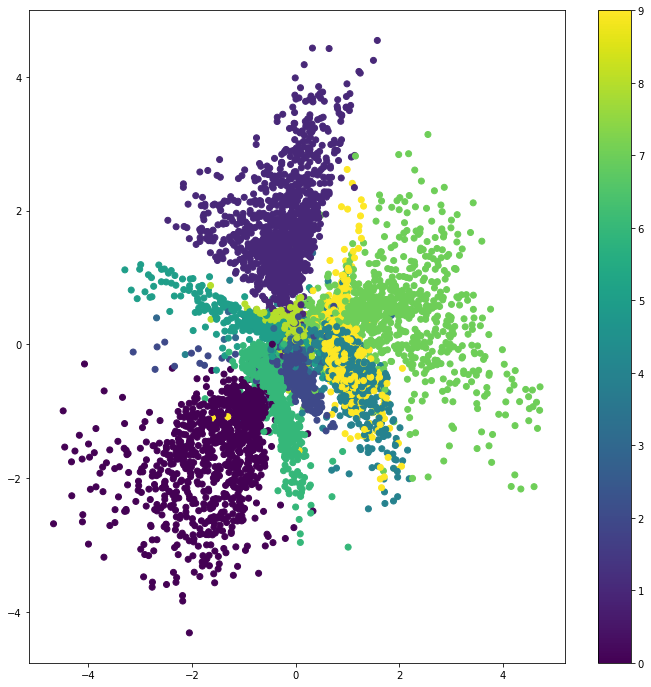

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_74 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_75 (Dense)             (None, 3136)              404544    
_________________________________________________________________
reshape_15 (Reshape)         (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 14, 14, 16)        2320      
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 14, 14, 16)        2320      
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 14, 14, 16)        2320      
__________

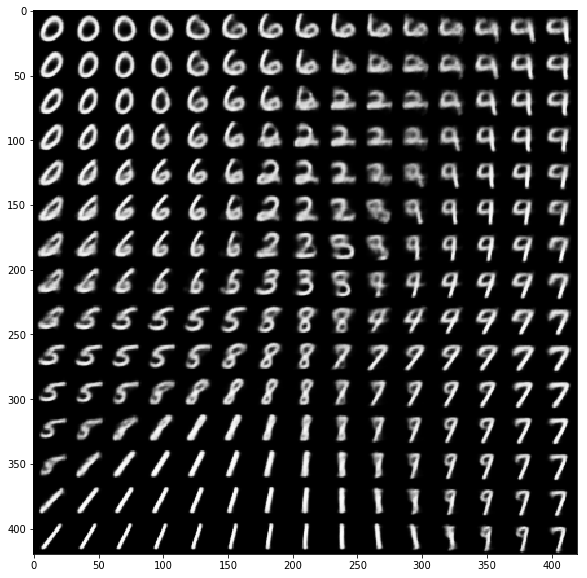

In [70]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(12, 12))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_d_v = decoder_v(decoder_input)
_d_upsample = decoder_upsample(_d_v)
_d_reshape = decoder_reshape(_d_upsample)
_d_h1 = decoder_h_1(_d_reshape)
_d_h2 = decoder_h_2(_d_h1)
_d_h3 = decoder_h_3(_d_h2)
_d_up_out = decoder_up_out(_d_h3)
_d_out = decoder_h_output(_d_up_out)

generator = Model(decoder_input, _d_out)

from keras.utils import plot_model
plot_model(generator, to_file='generator.png', show_shapes=True)
print(generator.summary())

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [ ]:
## result = vae.predict(x_test[0:2])
print(result.shape)

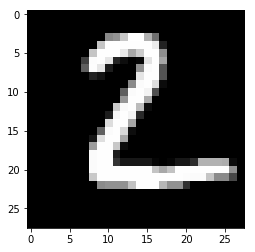

In [20]:
plt.imshow(x_test[1].reshape((28,28)).astype('float32')/ 255., cmap='Greys_r')